<a href="https://colab.research.google.com/github/haotruongnhat/colab_notebooks/blob/master/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%capture
!pip install pyyaml==5.1 pycocotools>=2.0.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
%%capture
!pip install pascal-voc-tools
from pascal_voc_tools import *
parser = XmlParser()

In [6]:
import torch, torchvision

# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import os
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.utils.visualizer import ColorMode
from detectron2.data.detection_utils import read_image

from detectron2.structures import BoxMode
from pathlib import Path
from joblib import Parallel, delayed

from tqdm import tqdm

In [7]:
def check_file_verified(path):
  if isinstance(path, list):
    return Parallel(n_jobs=40)(delayed(check_file_verified)(p) for p in path)
  else:
    with open(path, "r") as f:
      content = f.read()
    
    return bool(content.count('verified'))

def calculate_proportion(sum_, train_ratio, val_ratio):
  lenghts = []
  lenghts.append(int(np.ceil(sum_*train_ratio)))

  # rest_ratio = (1-train_ratio)/2
  lenghts.append(int(sum_*val_ratio))

  lenghts.append(sum_ - sum(lenghts))

  return lenghts

def random_indices(output_size, total_num):
  from numpy.random import default_rng

  rng = default_rng()
  index = rng.choice(total_num, size=output_size, replace=False)
  
  return list(index)

def generate_dataset_indices(total_samples, test_ratio, val_ratio=0.0):
  train_ratio = 1.0 - test_ratio - val_ratio

  train_num_samples, val_num_samples, test_num_samples = calculate_proportion(total_samples, train_ratio, val_ratio)
  train_indices = random_indices(train_num_samples, total_samples)
  val_indices = random_indices(val_num_samples, total_samples - train_num_samples)
  
  return train_indices, val_indices

def del_numpy(l, id_to_del):
  return np.delete(l, id_to_del)

def output_set(paths, all_to_train=False):
  path_array = np.array(paths)

  is_verified = np.array(check_file_verified(xml_paths))

  unverified_annotations_indices = list(np.where(is_verified == False)[0])

  unverified_to_test_list = list(path_array[unverified_annotations_indices])

  path_the_rest = del_numpy(path_array, unverified_annotations_indices)

  # subset_indices = generate_dataset_indices(len(path_the_rest), 0.15)
  # train_files = path_the_rest[subset_indices[0]]
  # path_the_rest = del_numpy(path_the_rest, subset_indices[0])
  # val_files = path_the_rest[subset_indices[1]]
  # test_files = del_numpy(path_the_rest, subset_indices[1])

  train_files = path_the_rest if not all_to_train else list(path_array)
  val_files = []
  test_files = []

  return {'train': list(train_files), 
          'val': list(val_files), 
          'test': list(test_files) + unverified_to_test_list}

In [8]:
def get_steel_dicts(paths):
  # xml_paths = list(annotations_path.glob("*.xml"))

  dataset_dicts = []

  for i, path in enumerate(paths):
    annotation = parser.load(path)

    record = {}
    record['file_name'] = str(images_set / annotation['filename'])
    record['image_id'] = i
    record['height'] = int(annotation['size']['height'])
    record['width'] = int(annotation['size']['width'])

    objs = []
    for obj in annotation['object']:
      objs.append({
          "bbox": list(map(float,[obj['bndbox']['xmin'],obj['bndbox']['ymin'],obj['bndbox']['xmax'],obj['bndbox']['ymax']])),
          "bbox_mode": BoxMode.XYXY_ABS,
          #"segmentation": [poly], To draw a line, along to ballon
          #you will need this for mask RCNN
          "category_id": 0,
          "iscrowd": 0
      })
    record["annotations"] = objs
    dataset_dicts.append(record)

  return dataset_dicts


In [9]:
dataset_folder = Path("/content/drive/My Drive/VSTech/CountingSteel/VOC/Factory")

annotations = "PredictedAnnotations"#"Annotations"
images = "Gray"#"JPEGImages"
annotations_path = dataset_folder / annotations
images_set = dataset_folder / images

xml_paths = list(annotations_path.glob("*.xml"))

classes = ['thep']
dataset = output_set(xml_paths)

print('Number of samples -  Train: {}, Val: {}, Test: {}'.format(len(dataset['train']), len(dataset['val']), len(dataset['test'])))

Number of samples -  Train: 6, Val: 0, Test: 37


In [ ]:
# #Convert to gray

# from detectron2.data.detection_utils import read_image

# for p in images_set.glob('*.jpg'):
#   img = read_image(str(p), format = 'BGR')

#   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)#np.mean(im, axis=2)#
#   # three_channel_gray = np.transpose(np.tile(gray, (3,1,1)), (1, 2, 0)).astype(np.uint8)
#   cv2.imwrite(str( dataset_folder / "Gray" / p.name ), gray)

In [14]:
DatasetCatalog.clear()
for d in ['train', 'val', 'test']:
  DatasetCatalog.register("countingsteel_{}".format(d), lambda d=d: get_steel_dicts(dataset[d]))
  MetadataCatalog.get("countingsteel_{}".format(d)).set(thing_classes=["thep"])

steel_metadata = MetadataCatalog.get("countingsteel_train")

In [11]:
from fvcore.transforms.transform import Transform, CropTransform

class PadSquareTransform(Transform):
  def __init__(self, color = [0, 0, 0]):
    super().__init__()
    self._set_attributes(locals())

  def apply_image(self, img):
    old_h, old_w, old_channel = img.shape

    desired_size = old_h if old_h > old_w else old_h

    delta_h = desired_size - old_h
    delta_w = desired_size - old_w
    self.top_pad, bottom = delta_h//2, delta_h-(delta_h//2)
    self.left_pad, right = delta_w//2, delta_w-(delta_w//2)

    padded_im = cv2.copyMakeBorder(img, self.top_pad, bottom, self.left_pad, right, cv2.BORDER_CONSTANT, value=self.color)
    return padded_im

  def apply_coords(self, coords):
    coords[:, 0] = coords[:, 0] + self.left_pad
    coords[:, 1] = coords[:, 1] + self.top_pad

    return coords

class Grayscale3DimTransform(Transform):
  def __init__(self):
    super().__init__()
    self._set_attributes(locals())

  def apply_image(self, img):
    # three_channel_gray = np.zeros(img.shape)
    gray = np.mean(img, axis=2)#cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # three_channel_gray[:, :, 0], three_channel_gray[:, :, 1], three_channel_gray[:, :, 2] = gray, gray, gray
    three_channel_gray = np.transpose(np.tile(gray, (3,1,1)), (1, 2, 0))
    return three_channel_gray.astype(np.uint8)

  def apply_coords(self, coords):
    return coords

from detectron2.data.transforms.augmentation import Augmentation

class GrayScaleAug(Augmentation):
    def __init__(self):
      pass

    def get_transform(self, img):
      return Grayscale3DimTransform()


In [12]:
from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
import logging

class CustomDatasetMapper(DatasetMapper):
	def __init__(self, cfg, is_train=True):
		super().__init__(cfg, is_train)
		if is_train:
			tfm_gens = [CropTransform(0, 500, 3024, 1700),
				          T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING),
									T.RandomFlip(),
									T.RandomFlip(horizontal=False, vertical=True)]
									# T.RandomApply(T.RandomRotation((-90, 90), center = (0.5, 0.5)))
		else:
			tfm_gens = [T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MAX_SIZE_TEST)]

		self.augmentations = tfm_gens
		print("============== CustomTransforms used in training: " + str(self.augmentations))

class CustomTrainer(DefaultTrainer):
  # @classmethod
  # def build_test_loader(cls, cfg, dataset_name):
  #     return build_detection_test_loader(cfg, mapper=CustomDatasetMapper(cfg, False))
  @classmethod
  def build_train_loader(cls, cfg):
      return build_detection_train_loader(cfg, mapper=CustomDatasetMapper(cfg, True))

[07/05 09:59:19 d2.data.dataset_mapper]: Augmentations used in training: [<fvcore.transforms.transform.CropTransform object at 0x7f651be54898>, ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomFlip(horizontal=False, vertical=True)]


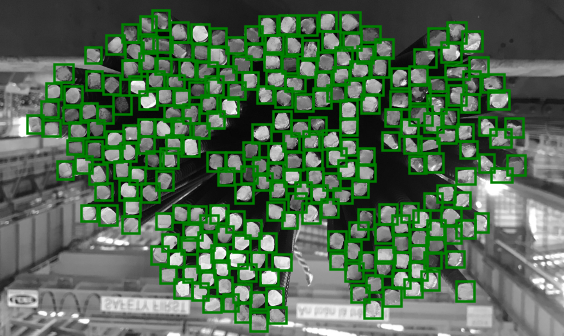

In [53]:
# mapper = CustomDatasetMapper(cfg, True)
def instances_to_voc(im, instances, name, is_train=False):
    im_height, im_width, im_depth = im.shape

    output_annotation = copy.deepcopy(templates)
    output_annotation['filename'] = name#fp.name

    output_annotation['size']['width'], output_annotation['size']['height'], output_annotation['size']['depth'] = str(im_width), str(im_height), str(im_depth)
    for cls_idx, bbox in zip(instances.get('gt_classes' if is_train else 'pred_classes').cpu(), instances.get('gt_boxes' if is_train else 'pred_boxes').tensor.cpu()):
      bbox_template = copy.deepcopy(object_template)
      bbox_template['name'] = steel_metadata.thing_classes[cls_idx.item()]
      bbox_template['bndbox']['xmin'] = int(bbox[0].item())
      bbox_template['bndbox']['ymin'] = int(bbox[1].item())
      bbox_template['bndbox']['xmax'] = int(bbox[2].item())
      bbox_template['bndbox']['ymax'] = int(bbox[3].item())
      output_annotation['object'].append(bbox_template)

    return output_annotation

def show_mapped_image(mapped_dict):
  # print(np.array(mapped_dict['image']).shape)
  v = Visualizer(np.transpose(np.array(mapped_dict['image']), (1, 2, 0))[:, :, ::-1], metadata=steel_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)

  for i, box in enumerate(mapped_dict['instances'].get('gt_boxes').tensor):
    min_x, min_y, max_x, max_y = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
    v.draw_box([min_x, min_y, max_x, max_y], alpha=1, edge_color="g", line_style="-")

  cv2_imshow(v.output.get_image()[:, :, ::-1])

# dicts = get_steel_dicts(dataset['train'])
# md = mapper(dicts[0])
# show_mapped_image(md)
# augmentation_folder = Path("/content/drive/My Drive/VSTech/CountingSteel/VOC/Factory/Augmentation")
dicts = get_steel_dicts(dataset['train'])
md = mapper(dicts[0])
show_mapped_image(md)

# for i in range(10):
#   for index, d in enumerate(dicts):
#     md = mapper(d)

#     file_name = "{}_{}_{}".format(Path(md['file_name']).stem, i, index)

#     output_annotation = instances_to_voc(md['image'], md['instances'], file_name + '.jpg', True)

#     cv2.imwrite(str(augmentation_folder / "JPEGImages" / (file_name+ '.jpg')), md["image"].numpy().transpose((1, 2, 0))[:, :, 0])
#     parser.save(augmentation_folder / "PredictedAnnotations" / '{}.xml'.format(file_name), output_annotation)


In [54]:
md['image'].shape

torch.Size([3, 672, 1129])

In [21]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("countingsteel_train",)
cfg.DATASETS.TEST = ("countingsteel_train",)
cfg.DATALOADER.NUM_WORKERS = 0#40
cfg.SOLVER.IMS_PER_BATCH = 4#4
cfg.SOLVER.BASE_LR = 0.00025#0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128#128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256]]
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.7]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model retinanet_R_101_FPN_3x.yaml
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/My Drive/VSTech/CountingSteel/Checkpoints/steel-faster-rcnn_detectron2_v3.pth")

cfg.INPUT.MAX_SIZE_TRAIN = 2000
cfg.INPUT.MAX_SIZE_TEST = 2000

mapper = DatasetMapper(is_train = True, augmentations=
                       [T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING),
                        T.RandomFlip(),
                        T.RandomFlip(horizontal=False, vertical=True)], image_format = 'BGR')

# cfg.TEST.AUG.ENABLED = True
# cfg.TEST.AUG.EVAL_PERIOD = 400

class CustomTrainer(DefaultTrainer):
  @classmethod
  def build_train_loader(cls, cfg):
    return build_detection_train_loader(cfg, mapper=mapper)

  @classmethod
  def build_test_loader(cls, cfg, dataset_name):
    return build_detection_test_loader(cfg, dataset_name)



[07/05 15:05:15 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=2000, sample_style='choice'), RandomFlip(), RandomFlip(horizontal=False, vertical=True)]


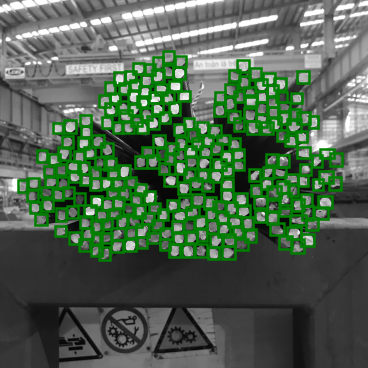

torch.Size([3, 736, 736])

In [22]:
def show_mapped_image(mapped_dict):
  # print(np.array(mapped_dict['image']).shape)
  v = Visualizer(np.transpose(np.array(mapped_dict['image']), (1, 2, 0))[:, :, ::-1], metadata=steel_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)

  for i, box in enumerate(mapped_dict['instances'].get('gt_boxes').tensor):
    min_x, min_y, max_x, max_y = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
    v.draw_box([min_x, min_y, max_x, max_y], alpha=1, edge_color="g", line_style="-")

  cv2_imshow(v.output.get_image()[:, :, ::-1])

# dicts = get_steel_dicts(dataset['train'])
# md = mapper(dicts[0])
# show_mapped_image(md)
# augmentation_folder = Path("/content/drive/My Drive/VSTech/CountingSteel/VOC/Factory/Augmentation")
dicts = get_steel_dicts(dataset['train'])
md = mapper(dicts[0])
show_mapped_image(md)
md['image'].shape

In [23]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = CustomTrainer(cfg)
# trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)
trainer.train()

torch.save(trainer.model.state_dict(), 
           os.path.join("/content/drive/My Drive/VSTech/CountingSteel/Checkpoints",
                        "steel-faster-rcnn_detectron2_v4_small_sample.pth"))

[07/05 15:05:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


[07/05 15:06:20 d2.utils.events]:  eta: 1:03:09  iter: 19  total_loss: 1.059  loss_cls: 0.389  loss_box_reg: 0.195  loss_rpn_cls: 0.327  loss_rpn_loc: 0.160  time: 1.9260  data_time: 1.6050  lr: 0.000005  max_mem: 4889M
[07/05 15:06:58 d2.utils.events]:  eta: 1:02:17  iter: 39  total_loss: 0.864  loss_cls: 0.324  loss_box_reg: 0.204  loss_rpn_cls: 0.143  loss_rpn_loc: 0.154  time: 1.9074  data_time: 1.3873  lr: 0.000010  max_mem: 4889M
[07/05 15:07:36 d2.utils.events]:  eta: 1:01:13  iter: 59  total_loss: 0.668  loss_cls: 0.253  loss_box_reg: 0.214  loss_rpn_cls: 0.071  loss_rpn_loc: 0.136  time: 1.9017  data_time: 1.3906  lr: 0.000015  max_mem: 4889M
[07/05 15:08:14 d2.utils.events]:  eta: 1:00:29  iter: 79  total_loss: 0.580  loss_cls: 0.183  loss_box_reg: 0.202  loss_rpn_cls: 0.055  loss_rpn_loc: 0.126  time: 1.8981  data_time: 1.3853  lr: 0.000020  max_mem: 4889M
[07/05 15:08:52 d2.utils.events]:  eta: 0:59:58  iter: 99  total_loss: 0.520  loss_cls: 0.169  loss_box_reg: 0.196  loss

KeyboardInterrupt: ignored

In [16]:
torch.save(trainer.model.state_dict(), os.path.join("/content/drive/My Drive/VSTech/CountingSteel/Checkpoints","steel-faster-rcnn_detectron2_v4_small_sample.pth"))

In [18]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.DATASETS.TRAIN = ("countingsteel_train",)
cfg.DATASETS.TEST = ("countingsteel_train",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/My Drive/VSTech/CountingSteel/Checkpoints/steel-faster-rcnn_detectron2_v3.pth")
# cfg.DATASETS.TEST = ("countingsteel_test", )

predictor = DefaultPredictor(cfg)

In [24]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("countingsteel_train", cfg, False, output_dir="./output/")

test_mapper = DatasetMapper(is_train = False, augmentations=
                       [CropTransform(0, 400, 3024, 1800),
                        T.ResizeShortestEdge(800, 1500)], image_format = 'BGR')

val_loader = build_detection_test_loader(cfg, "countingsteel_train")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[07/05 16:06:13 d2.evaluation.coco_evaluation]: 'countingsteel_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/05 16:06:13 d2.data.datasets.coco]: Converting annotations of dataset 'countingsteel_train' to COCO format ...)
[07/05 16:06:13 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/05 16:06:13 d2.data.datasets.coco]: Conversion finished, #images: 6, #annotations: 1595
[07/05 16:06:13 d2.data.datasets.coco]: Caching COCO format annotations at './output/countingsteel_train_coco_format.json' ...
[07/05 16:06:13 d2.data.dataset_mapper]: Augmentations used in training: [<fvcore.transforms.transform.CropTransform object at 0x7f32f2309e10>, ResizeShortestEdge(short_edge_length=(800, 800), max_size=1500)]
[07/05 16:06:13 d2.data.common]: Serializing 6 elements to byte tensors and concatenating them all ...
[07/05 16:06:13 d2.data.common]: Serialized dataset takes 0.09 MiB
[07/05 16:06:13 d2.data.dataset_mapp

OrderedDict([('bbox',
              {'AP': 28.847176594971565,
               'AP50': 37.62376237623762,
               'AP75': 36.34129208741185,
               'APl': 31.677343506939177,
               'APm': 27.87846043205179,
               'APs': nan})])

In [19]:
import copy

class OUTPUT_TYPE:
  LABEL = 0
  IMAGE = 1
  SHOW = 2

templates = dict(
      filename = '',
      folder = '',
      path = '',
      source= dict(database = 'Unknown'),
      size = dict(width = '1000', height='1000', depth='1'),
      segmented = '0',
      object = []
    )

object_template = dict(
  name = '',
  pose = 'Unspecified',
  truncated = '0',
  difficult = '0',
  bndbox = dict(xmin = '0', ymin = '0', xmax = '0', ymax = '0')
)

def predict(image_path, output_type, scale = 1, is_drop=True, expand_ratio = 0.05, ext_glob = '*.jpg'):
  if Path(image_path).is_file():
    file_paths = [image_path]
  else:
    path = Path(image_path)
    file_paths = list(path.glob(ext_glob))

  if output_type == OUTPUT_TYPE.LABEL:
    output_path = path / 'label'

    
  elif output_type == OUTPUT_TYPE.IMAGE:
    output_path = path / 'image'

  if output_type != OUTPUT_TYPE.SHOW:
    if not output_path.is_dir():
      os.makedirs(output_path)

  train_set_file_name = [p.stem for p in dataset['train']]

  with tqdm(total=len(file_paths), position=0, leave=True) as pbar:
    for fp in file_paths[:]:
      im = read_image(str(fp), format="BGR")
      outputs = predictor(im)
      instances = outputs['instances']
      v = Visualizer(im[:, :, ::-1],
                    metadata=steel_metadata, 
                    scale=scale, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )

      if output_type == OUTPUT_TYPE.LABEL:
        output_annotation = instances_to_voc(im, instances, fp.name)

        if not (fp.stem in train_set_file_name):
          parser.save(output_path / '{}.xml'.format(fp.stem), output_annotation)
          pbar.set_postfix(file=output_path / '{}.xml'.format(fp.stem), refresh=False)

        pbar.update()
      elif (output_type == OUTPUT_TYPE.IMAGE) or (output_type == OUTPUT_TYPE.SHOW):

        min_x= int(min(instances.get('pred_boxes').tensor[:, 0]).item() * (1-expand_ratio))
        min_y = int(min(instances.get('pred_boxes').tensor[:, 1]).item()* (1-expand_ratio))
        max_x = int(max(instances.get('pred_boxes').tensor[:, 2]).item()* (1+expand_ratio))
        max_y = int(max(instances.get('pred_boxes').tensor[:, 3]).item()* (1+expand_ratio))

        for i, (box, score) in enumerate(zip(instances.get('pred_boxes').tensor, instances.get('scores'))):
          v.draw_text(str(round(score.item(),3)), (int((box[0] + box[2])/2) , int((box[1] + box[3])/2) - 10), font_size= 7, color='r')
          v.draw_circle(( int((box[0] + box[2])/2) , int((box[1] + box[3])/2)), 'g', radius=int((box[2] - box[0])/4))

        out = v.output.get_image()
        if is_drop:
          out = out[min_y:max_y, min_x:max_x, ::-1] 
        else:
          out = out[:, :, ::-1] 

        if output_type == OUTPUT_TYPE.SHOW:
          cv2_imshow(out)
        else:
          cv2.imwrite(str(output_path / '{}.jpg'.format(fp.stem)), out)
          pbar.set_postfix(file=output_path / '{}.jpg'.format(fp.stem), refresh=False)
        pbar.update()

  0%|          | 0/1043 [00:00<?, ?it/s]

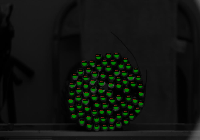

  0%|          | 1/1043 [00:00<16:43,  1.04it/s]

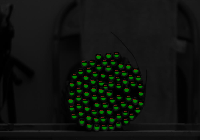

  0%|          | 2/1043 [00:06<41:24,  2.39s/it]

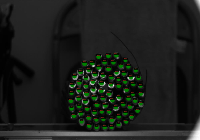

  0%|          | 3/1043 [00:07<32:48,  1.89s/it]

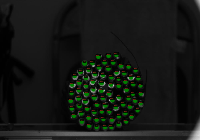

  0%|          | 4/1043 [00:08<26:37,  1.54s/it]

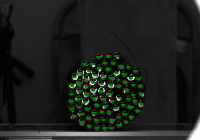

  0%|          | 5/1043 [00:08<22:07,  1.28s/it]

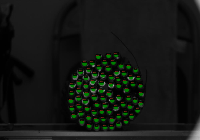

  1%|          | 6/1043 [00:09<18:43,  1.08s/it]

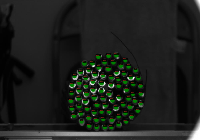

  1%|          | 7/1043 [00:10<16:23,  1.05it/s]

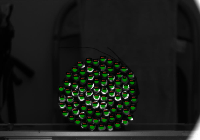

  1%|          | 8/1043 [00:11<16:46,  1.03it/s]

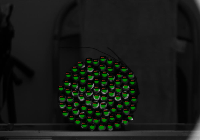

  1%|          | 9/1043 [00:11<15:46,  1.09it/s]

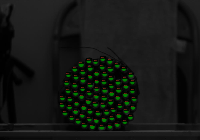

  1%|          | 10/1043 [00:12<14:14,  1.21it/s]

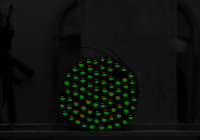

  1%|          | 11/1043 [00:13<13:39,  1.26it/s]

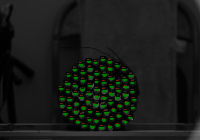

  1%|          | 12/1043 [00:13<13:20,  1.29it/s]

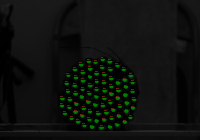

  1%|          | 13/1043 [00:14<12:36,  1.36it/s]

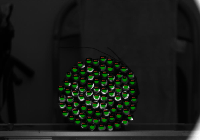

  1%|▏         | 14/1043 [00:15<12:04,  1.42it/s]

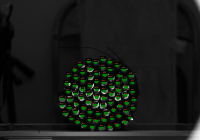

  1%|▏         | 15/1043 [00:15<11:56,  1.44it/s]

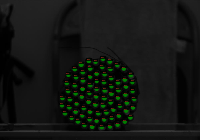

  2%|▏         | 16/1043 [00:16<11:36,  1.47it/s]

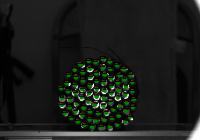

  2%|▏         | 17/1043 [00:17<12:11,  1.40it/s]

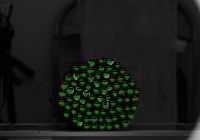

  2%|▏         | 18/1043 [00:17<11:52,  1.44it/s]

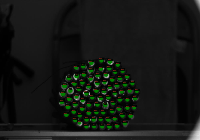

  2%|▏         | 19/1043 [00:18<11:39,  1.46it/s]

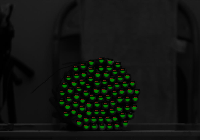

  2%|▏         | 20/1043 [00:19<11:27,  1.49it/s]

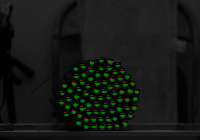

  2%|▏         | 21/1043 [00:20<16:14,  1.05it/s]

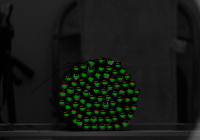

  2%|▏         | 22/1043 [00:21<16:28,  1.03it/s]

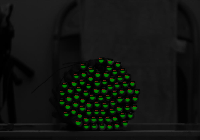

  2%|▏         | 23/1043 [00:22<14:36,  1.16it/s]

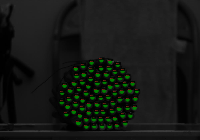

  2%|▏         | 24/1043 [00:23<14:20,  1.18it/s]

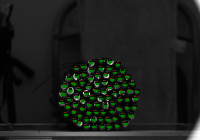

  2%|▏         | 25/1043 [00:24<13:57,  1.21it/s]

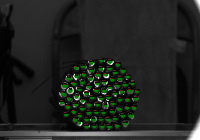

  2%|▏         | 26/1043 [00:24<12:38,  1.34it/s]

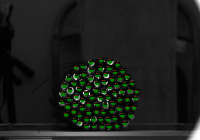

  3%|▎         | 27/1043 [00:25<12:29,  1.36it/s]

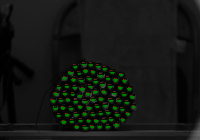

  3%|▎         | 28/1043 [00:25<11:49,  1.43it/s]

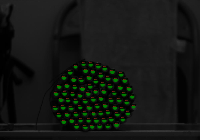

  3%|▎         | 29/1043 [00:26<11:39,  1.45it/s]

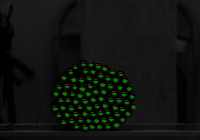

  3%|▎         | 30/1043 [00:27<11:09,  1.51it/s]

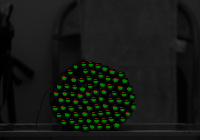

  3%|▎         | 31/1043 [00:27<10:49,  1.56it/s]

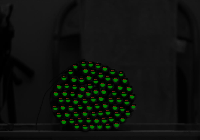

  3%|▎         | 32/1043 [00:28<10:43,  1.57it/s]

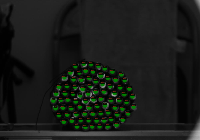

  3%|▎         | 33/1043 [00:29<11:29,  1.46it/s]

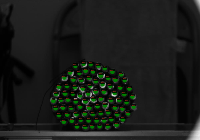

  3%|▎         | 34/1043 [00:29<11:06,  1.51it/s]

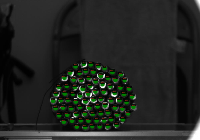

  3%|▎         | 35/1043 [00:30<10:54,  1.54it/s]

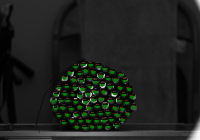

  3%|▎         | 36/1043 [00:31<11:02,  1.52it/s]

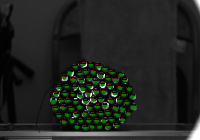

  4%|▎         | 37/1043 [00:32<13:42,  1.22it/s]

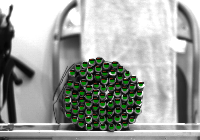

  4%|▎         | 38/1043 [00:33<13:19,  1.26it/s]

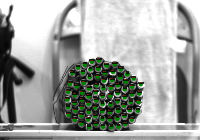

  4%|▎         | 39/1043 [00:33<12:49,  1.30it/s]

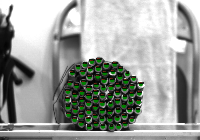

  4%|▍         | 40/1043 [00:34<13:27,  1.24it/s]

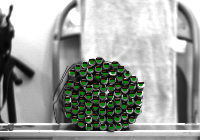

  4%|▍         | 41/1043 [00:35<13:14,  1.26it/s]

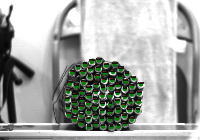

  4%|▍         | 42/1043 [00:36<13:14,  1.26it/s]

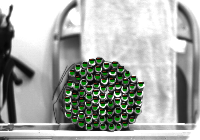

  4%|▍         | 43/1043 [00:36<12:35,  1.32it/s]

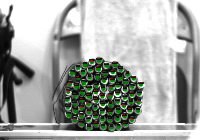

  4%|▍         | 44/1043 [00:37<13:17,  1.25it/s]

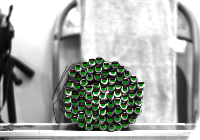

  4%|▍         | 45/1043 [00:38<12:02,  1.38it/s]

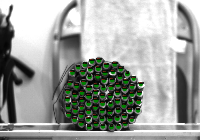

  4%|▍         | 46/1043 [00:39<12:05,  1.37it/s]

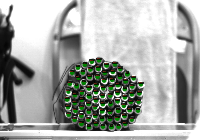

  5%|▍         | 47/1043 [00:39<11:46,  1.41it/s]

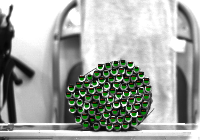

  5%|▍         | 48/1043 [00:40<12:13,  1.36it/s]

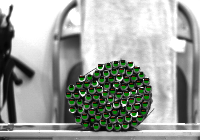

  5%|▍         | 49/1043 [00:41<12:45,  1.30it/s]

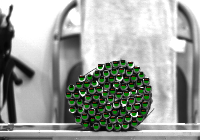

  5%|▍         | 50/1043 [00:42<12:22,  1.34it/s]

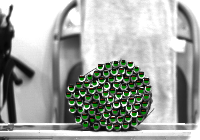

  5%|▍         | 51/1043 [00:42<12:05,  1.37it/s]

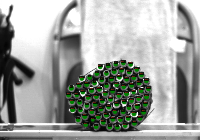

  5%|▍         | 52/1043 [00:43<11:45,  1.40it/s]

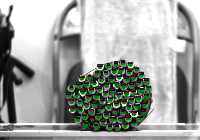

  5%|▌         | 53/1043 [00:44<11:22,  1.45it/s]

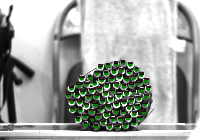

  5%|▌         | 54/1043 [00:44<11:13,  1.47it/s]

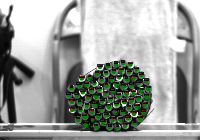

  5%|▌         | 55/1043 [00:45<11:15,  1.46it/s]

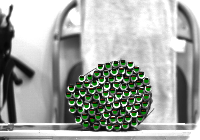

  5%|▌         | 56/1043 [00:46<11:39,  1.41it/s]

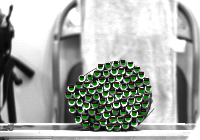

  5%|▌         | 57/1043 [00:46<11:34,  1.42it/s]

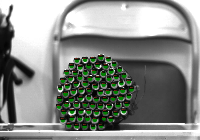

  6%|▌         | 58/1043 [00:47<11:20,  1.45it/s]

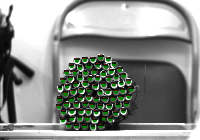

  6%|▌         | 59/1043 [00:48<11:49,  1.39it/s]

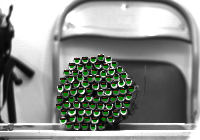

  6%|▌         | 60/1043 [00:49<11:32,  1.42it/s]

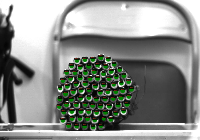

  6%|▌         | 61/1043 [00:49<11:07,  1.47it/s]

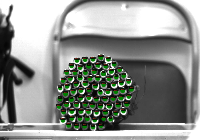

  6%|▌         | 62/1043 [00:50<11:08,  1.47it/s]

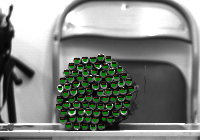

  6%|▌         | 63/1043 [00:51<11:15,  1.45it/s]

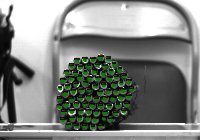

  6%|▌         | 64/1043 [00:51<11:30,  1.42it/s]

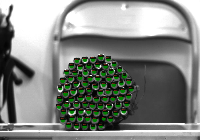

  6%|▌         | 65/1043 [00:52<11:30,  1.42it/s]

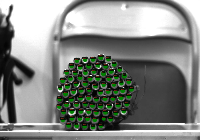

  6%|▋         | 66/1043 [00:53<11:23,  1.43it/s]

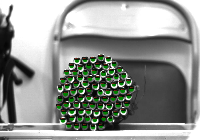

  6%|▋         | 67/1043 [00:53<11:32,  1.41it/s]

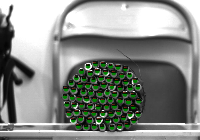

  7%|▋         | 68/1043 [00:54<11:01,  1.47it/s]

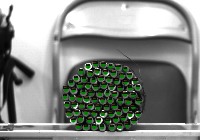

  7%|▋         | 69/1043 [00:55<11:08,  1.46it/s]

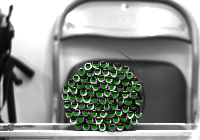

  7%|▋         | 70/1043 [00:56<11:49,  1.37it/s]

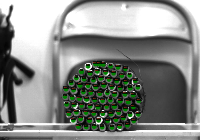

  7%|▋         | 71/1043 [00:57<13:02,  1.24it/s]


KeyboardInterrupt: ignored

In [20]:
predict("/content/drive/My Drive/VSTech/CountingSteel/VOC/Lab/JPEGImages", OUTPUT_TYPE.SHOW, scale = 0.2, is_drop=False, ext_glob='*.jpg')

['IMG_2731',
 'IMG_2693',
 'IMG_2694',
 'IMG_2695',
 'IMG_2737',
 'IMG_2696',
 'IMG_2698',
 'IMG_2726',
 'IMG_2736',
 'IMG_2733',
 'IMG_2734',
 'IMG_2735',
 'IMG_2711']